# Float Point Representation


У типов данных с плавающей точкой есть арифметические особенности:

**fp32**
$$
x + \delta == x,\,\mathrm{если}\; \delta < 5.96 \cdot 10^{-8} x
$$

К слову, это еще одна причина присматривать за величинами активаций, нормировать данные и таргет в случае регрессии. Можно было бы перейти на float64, но (вычислительно и по памяти) дешевле быть аккуратными на float32.



<img src="https://blogs.nvidia.com/wp-content/uploads/2020/05/tf32-Mantissa-chart-hi-res-FINAL-400x255.png.webp"/>

_картинка из статьи [NVIDIA](https://blogs.nvidia.com/blog/2020/05/14/tensorfloat-32-precision-format/)_

## Задача на сложение чисел с плавующей точкой

Есть массив чисел с плавующей точкой. Нужно найти сумму этих чисел.


In [ ]:
import numpy as np

float_array = np.exp(np.linspace(-15, 10, 100)).astype(np.float32)
float_array[:3], float_array[-3:]

In [ ]:
print("{:.8f} {:.8f}".format(float_array[0], float_array[-1]))

assert float_array[0] + float_array[-1] == float_array[-1]

In [ ]:
float_array[0] + float_array[1], float_array[0]

In [ ]:
from tqdm.auto import tqdm
import bisect

float_array = np.array([1e-10] * 10000 + [ 10 ] * 100 , dtype=np.float32)

# складываем от большего к меньшему
sum = 0
for elem in reversed(float_array):
    sum += elem

print("sum", sum)


# складываем от меньшего к большему
sum_sorted = 0
for elem in float_array:
    sum_sorted += elem

print("sum_sorted", sum_sorted)


# поддерживаем сортированость массива
# sum_keep_sorted = 0
# sorted_floats = float_array.tolist()
# for _ in tqdm(range(len(sorted_floats) - 1)):
#     sorted_floats = sorted(sorted_floats)
#
#     sum_least_elements = sorted_floats.pop(0) + sorted_floats.pop(0)
#     sorted_floats.insert(0, sum_least_elements)


# поддерживаем сортированость массива, оптимальный вариант
sum_keep_sorted_optim = 0
sorted_floats_optim = float_array.tolist()
for _ in tqdm(range(len(sorted_floats_optim) - 1)):
    # более оптимальный вариант
    sum_least_elements = sorted_floats_optim.pop(0) + sorted_floats_optim.pop(0)
    bisect.insort_left(sorted_floats_optim, sum_least_elements)
    if len(sorted_floats_optim) == 1:
        sum_keep_sorted_optim = sorted_floats_optim[0]

print("sum_keep_sorted_optim", sorted_floats_optim[0])

# для того, чтобы заметить разницу между sum_keep_sorted и sum_sorted надо 5.96 e8 элементов в массиве -- это массив, который будет весить порядка гигабайта и даже для более оптимального  варианта может долго вычисляться

# Cuda Async

In [ ]:
import torch
import torch.nn as nn

class BigMM(nn.Module):
    def __init__(self, hidden_dim=1000):
        super().__init__()

        self.hidden_dim = hidden_dim
        self.linear = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, input):
        return self.linear(input)

In [ ]:
bigmm = BigMM()

batch_size = 1024
hidden_dim = bigmm.hidden_dim
input_t = torch.rand([ batch_size,  hidden_dim])

In [ ]:
import time
import numpy as np

def hands_timeit_ms(callable, n_calls=100):
    elapsed = []
    for _ in range(n_calls):
        start_time = time.monotonic_ns()
        callable()
        elapsed.append(time.monotonic_ns() - start_time)

    mean_elapsed = np.mean(elapsed) / 1000000
    std_elapsed = np.std(elapsed) / 1000000

    print(f"elapsed: mean={mean_elapsed:.4f}ms  std={std_elapsed:.4f}ms")

    return mean_elapsed, std_elapsed


In [ ]:
device = 'cpu'

bigmm.to(device)
input_t = input_t.to(device)

def bigmm_cpu():
    result = bigmm(input_t)

print("CPU Linear Duration")
hands_timeit_ms(bigmm_cpu);

CPU Linear Duration
elapsed: mean=30.4695ms  std=7.2678ms


In [ ]:
import time
import numpy as np

def hands_timeit_cuda_ms(callable, n_calls=100):

    elapsed = []

    for _ in range(n_calls):
        start_event = torch.cuda.Event(enable_timing=True)
        end_event = torch.cuda.Event(enable_timing=True)
        start_event.record()

        callable()

        end_event.record()
        torch.cuda.synchronize() # Wait for the events to be recorded!
        elapsed_time_ms = start_event.elapsed_time(end_event)
        elapsed.append(elapsed_time_ms)

    mean_elapsed = np.mean(elapsed)
    std_elapsed = np.std(elapsed)

    print(f"elapsed: mean={mean_elapsed:.4f}ms  std={std_elapsed:.4f}ms")

    return mean_elapsed, std_elapsed


In [ ]:
device = 'cuda'

bigmm.to(device)
input_t = input_t.to(device)

def bigmm_gpu():
    result = bigmm(input_t)

def bigmm_gpu_with_cuda_synchronize():
    result = bigmm(input_t)
    torch.cuda.synchronize()

print("# Wall Clock Profiling:\n")

print("GPU Linear Duration No Synchonize")
hands_timeit_ms(bigmm_gpu, n_calls=100)

print()

print("GPU Linear Duration With Synchonize")
hands_timeit_ms(bigmm_gpu_with_cuda_synchronize, n_calls=100);

print("\n\n====\n\n# Events Profiling:\n")

print("GPU Linear Duration No Synchonize")
hands_timeit_cuda_ms(bigmm_gpu, n_calls=1000);

print()

print("GPU Linear Duration With Synchonize")
hands_timeit_cuda_ms(bigmm_gpu_with_cuda_synchronize, n_calls=1000);


# Wall Clock Profiling:

GPU Linear Duration No Synchonize
elapsed: mean=0.4978ms  std=4.1268ms

GPU Linear Duration With Synchonize
elapsed: mean=0.9731ms  std=9.6721ms


====

# Events Profiling:

GPU Linear Duration No Synchonize
elapsed: mean=0.5967ms  std=0.0310ms

GPU Linear Duration With Synchonize
elapsed: mean=0.6153ms  std=0.1134ms


### Wall Clock Timings Crutch

In [ ]:
MORE_N_CALLS=10000

print("GPU Linear Duration No Synchonize")
hands_timeit_ms(bigmm_gpu, n_calls=MORE_N_CALLS)

print()

print("GPU Linear Duration With Synchonize")
hands_timeit_ms(bigmm_gpu_with_cuda_synchronize, n_calls=MORE_N_CALLS);

GPU Linear Duration No Synchonize
elapsed: mean=0.6104ms  std=0.2369ms

GPU Linear Duration With Synchonize
elapsed: mean=0.6850ms  std=3.3145ms


## [Cuda Streams](https://docs.pytorch.org/docs/stable/notes/cuda.html#asynchronous-execution)

In [ ]:

S1 = torch.cuda.Stream()  # Create a new stream.
S2 = torch.cuda.Stream()  # Create a new stream.

device = 'cuda'

bigmm.to(device)
input_t = input_t.to(device)

torch.cuda.synchronize() # ❓❓❓

with torch.cuda.stream(S1):
    s1_output = bigmm(input_t)

with torch.cuda.stream(S2):
    s2_output = bigmm(input_t)

# Wait for all kernels in all streams on a CUDA device to complete.
torch.cuda.synchronize()

assert (s1_output == s2_output).all()

In [ ]:
S1 = torch.cuda.Stream()  # Create a new stream.
S2 = torch.cuda.Stream()  # Create a new stream.

def bigmm_gpu_1_streams():
    with torch.cuda.stream(S1):
        s1_output = bigmm(input_t)

print("GPU Linear Duration 1 streams")
hands_timeit_cuda_ms(bigmm_gpu_1_streams, n_calls=1000);

print()

def bigmm_gpu_2_streams():
    with torch.cuda.stream(S1):
        s1_output = bigmm(input_t)

    with torch.cuda.stream(S2):
        s2_output = bigmm(input_t)

print("GPU Linear Duration 2 streams")
hands_timeit_cuda_ms(bigmm_gpu_2_streams, n_calls=1000);

print()

def bigmm_gpu_default_stream():
    s1_output = bigmm(input_t)

print("GPU Linear Duration Default stream")
hands_timeit_cuda_ms(bigmm_gpu_default_stream, n_calls=1000);

GPU Linear Duration 1 streams
elapsed: mean=0.1121ms  std=0.0624ms

GPU Linear Duration 2 streams
elapsed: mean=0.1848ms  std=0.0470ms

GPU Linear Duration Default stream
elapsed: mean=0.6276ms  std=0.0438ms


Почему отдельный стрим быстрее дефолтного❓

<!-- Все хорошо, мы просто неправильно измеряем! -->

<!-- https://github.com/pytorch/pytorch/blob/134179474539648ba7dee1317959529fbd0e7f89/torch/cuda/streams.py#L179 -->

<!-- event.record(stream=None) по умолчанию берет дефолтный временной стрим. И мы измеряем только накладные расходы дефолтного стрима для запуска других стримов. -->

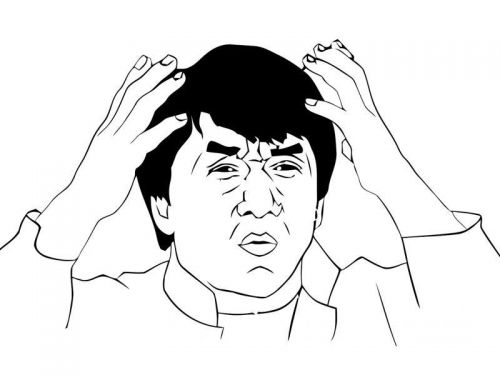


In [ ]:
S1 = torch.cuda.Stream()  # Create a new stream.
S2 = torch.cuda.Stream()  # Create a new stream.


def bigmm_gpu_default_stream():
    output = bigmm(input_t)

print("GPU Linear Duration Default stream")
hands_timeit_cuda_ms(bigmm_gpu_default_stream, n_calls=1000);

print()

def bigmm_gpu_default_stream_with_1_extra_stream():
    output = bigmm(input_t)

    with torch.cuda.stream(S1):
        s1_output = bigmm(input_t)


print("GPU Linear Duration Default stream + 1")
hands_timeit_cuda_ms(bigmm_gpu_default_stream_with_1_extra_stream, n_calls=1000);

print()

def bigmm_gpu_default_stream_with_2_extra_stream():
    output = bigmm(input_t)

    with torch.cuda.stream(S1):
        s1_output = bigmm(input_t)

    with torch.cuda.stream(S2):
        s2_output = bigmm(input_t)


print("GPU Linear Duration Default stream + 2")
hands_timeit_cuda_ms(bigmm_gpu_default_stream_with_2_extra_stream, n_calls=1000);

GPU Linear Duration Default stream
elapsed: mean=0.6784ms  std=0.1483ms

GPU Linear Duration Default stream + 1
elapsed: mean=0.7851ms  std=0.0502ms

GPU Linear Duration Default stream + 2
elapsed: mean=0.8531ms  std=0.0382ms


In [ ]:
S1 = torch.cuda.Stream()  # Create a new stream.
S2 = torch.cuda.Stream()  # Create a new stream.

def bigmm_gpu_default_stream():
    output = bigmm(input_t)

print("GPU Linear Duration Default stream")
hands_timeit_cuda_ms(bigmm_gpu_default_stream, n_calls=1000);

print()

def bigmm_gpu_default_stream_x3_linears():
    output = bigmm(input_t)
    output1 = bigmm(input_t)
    output2 = bigmm(input_t)

print("GPU Linear Duration Default stream x3 Linears")
hands_timeit_cuda_ms(bigmm_gpu_default_stream_x3_linears, n_calls=1000);

print()

def bigmm_gpu_default_stream_x3_batch_size():
    output = bigmm(torch.cat([input_t, input_t, input_t], dim=0))

print("GPU Linear Duration Default stream x3 Batch Size")
hands_timeit_cuda_ms(bigmm_gpu_default_stream_x3_batch_size, n_calls=1000);




GPU Linear Duration Default stream
elapsed: mean=0.7119ms  std=0.0841ms

GPU Linear Duration Default stream x3 Linears
elapsed: mean=2.3308ms  std=0.2380ms

GPU Linear Duration Default stream x3 Batch Size
elapsed: mean=1.9641ms  std=0.1194ms


# Torch Compile

Fused Kernels / Non-Fused Kernels Example

## ✅ Fusion Expected:

Element-wise operations like torch.sin, torch.cos, +, * — these are commonly fused.

## ❌ No Fusion Expected:

torch.matmul, nn.Linear, or control flow — these typically generate separate kernels.



### Torch Compile Kernels Fusion

* Reduces GPU Memory Usage - do not need to store activations

In [ ]:
import torch
import torch.nn as nn
import torch._dynamo

# Enable verbose logging to observe what gets compiled
torch._dynamo.config.verbose = True

# Define a module with both fusable and non-fusable operations
class MixedOpsModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(64, 64)

    def forward(self, x):
        # Fusable: element-wise ops (these can be fused into one kernel)
        y = torch.sin(x) + torch.cos(x) * x

        # Non-fusable: matmul / linear ops (usually separate kernels)
        z = self.linear(x)

        # Combine results (element-wise add: potentially fusable with previous ops)
        return y + z

# Create an instance of the model
model = MixedOpsModel()

# Compile the model
compiled_model = torch.compile(model, backend="inductor", fullgraph=True)

# Dummy input
input_tensor = torch.randn(32, 64)

# Run the compiled model
output = compiled_model(input_tensor)

print("Output shape:", output.shape)



Output shape: torch.Size([32, 64])


In [ ]:
!find /tmp/torchinductor_root -name '*.py'

/tmp/torchinductor_root/du/cduk6vovv5ofxctnnvxdbys4pe4q6u2eqyvn5ggy4brrithsqqnz.py


In [ ]:
!cat /tmp/torchinductor_root/du/cduk6vovv5ofxctnnvxdbys4pe4q6u2eqyvn5ggy4brrithsqqnz.py


# AOT ID: ['0_forward']
from ctypes import c_void_p, c_long, c_int
import torch
import math
import random
import os
import tempfile
from math import inf, nan
from torch._inductor.hooks import run_intermediate_hooks
from torch._inductor.utils import maybe_profile
from torch._inductor.codegen.memory_planning import _align as align
from torch import device, empty_strided
from torch._inductor.async_compile import AsyncCompile
from torch._inductor.select_algorithm import extern_kernels
from torch._inductor.codegen.multi_kernel import MultiKernelCall

aten = torch.ops.aten
inductor_ops = torch.ops.inductor
_quantized = torch.ops._quantized
assert_size_stride = torch._C._dynamo.guards.assert_size_stride
empty_strided_cpu = torch._C._dynamo.guards._empty_strided_cpu
empty_strided_cuda = torch._C._dynamo.guards._empty_strided_cuda
empty_strided_xpu = torch._C._dynamo.guards._empty_strided_xpu
reinterpret_tensor = torch._C._dynamo.guards._reinterpret_tensor
alloc_from_pool = torch.ops.inductor._

# Profiling

### Topics:

* PyTorch Profiler, Nsight, Chrome Tracing
* Chrome tracing / flame graphs / memory profiles
* Bottleneck detection (CPU, GPU, data)
* Memory vs compute bottlenecks


# GPT2 Finetuning pipeline

* Batch Size
* Mixed Precision
* Add SDPA
* Add Torch Compile
* Add Peft - LoRA



In [3]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, HfArgumentParser
import numpy as np
import torch

import os
os.environ['WANDB_DISABLED'] = 'true'

# Code from https://huggingface.co/docs/transformers/en/training

# Load and process dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer, DataCollatorForLanguageModeling
from datasets import Dataset
import torch

# Load dataset
dataset = load_dataset('HuggingFaceFW/fineweb', data_files=['data/CC-MAIN-2024-10/000_00000.parquet'])

dataset['train'] = dataset['train'].select(range(2000))

# Load tokenizer and model
model_name = "gpt2"  # base model (not instruction-tuned)
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token  # needed for padding

# Tokenize dataset
def tokenize_function(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=1024)

tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Data collator
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)


Map: 100%|██████████| 2000/2000 [00:01<00:00, 1633.14 examples/s]


### Baseline batch_size=24

In [4]:
model = AutoModelForCausalLM.from_pretrained(model_name)

# Training arguments
training_args = TrainingArguments(
    output_dir="./gpt2-finetuned",
    overwrite_output_dir=True,
    num_train_epochs=1,
    per_device_train_batch_size=24,
    save_steps=1000000,
    logging_steps=1000000,
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipykernel_466586/2221802360.py:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss


TrainOutput(global_step=84, training_loss=3.424278985886347, metrics={'train_runtime': 126.2402, 'train_samples_per_second': 15.843, 'train_steps_per_second': 0.665, 'total_flos': 1045168128000000.0, 'train_loss': 3.424278985886347, 'epoch': 1.0})

## Mixed Precision

In [5]:
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
)

# Training arguments
training_args = TrainingArguments(
    output_dir="./gpt2-finetuned",
    overwrite_output_dir=True,
    num_train_epochs=1,
    per_device_train_batch_size=24,
    save_steps=1000000,
    logging_steps=1000,
    bf16=True,
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipykernel_466586/693092341.py:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss


TrainOutput(global_step=84, training_loss=3.51228514171782, metrics={'train_runtime': 41.3287, 'train_samples_per_second': 48.392, 'train_steps_per_second': 2.032, 'total_flos': 1045168128000000.0, 'train_loss': 3.51228514171782, 'epoch': 1.0})

### SDPA


In [6]:
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    attn_implementation="sdpa",
)

# Training arguments
training_args = TrainingArguments(
    output_dir="./gpt2-finetuned",
    overwrite_output_dir=True,
    num_train_epochs=1,
    per_device_train_batch_size=24,
    save_steps=1000000,
    logging_steps=1000,
    bf16=True,
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipykernel_466586/4178687319.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss


TrainOutput(global_step=84, training_loss=3.5121637980143228, metrics={'train_runtime': 41.2294, 'train_samples_per_second': 48.509, 'train_steps_per_second': 2.037, 'total_flos': 1045168128000000.0, 'train_loss': 3.5121637980143228, 'epoch': 1.0})

### Torch Compile



In [7]:
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    attn_implementation="sdpa",
)

# Training arguments
training_args = TrainingArguments(
    output_dir="./gpt2-finetuned",
    overwrite_output_dir=True,
    num_train_epochs=1,
    per_device_train_batch_size=24,
    save_steps=1000000,
    logging_steps=1000,
    bf16=True,
    torch_compile=True,
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipykernel_466586/3035546345.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss


TrainOutput(global_step=84, training_loss=3.510979425339472, metrics={'train_runtime': 53.1922, 'train_samples_per_second': 37.599, 'train_steps_per_second': 1.579, 'total_flos': 1045168128000000.0, 'train_loss': 3.510979425339472, 'epoch': 1.0})

### Add Peft - LoRA

In [ ]:
!pip install peft

In [8]:
from peft import get_peft_model, LoraConfig, TaskType

# Load base model
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    attn_implementation="sdpa",
)

# PEFT configuration for LoRA
peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    inference_mode=False,
    r=8,
    lora_alpha=32,
    lora_dropout=0.05
)

# Wrap base model with LoRA
model = get_peft_model(base_model, peft_config)
model.print_trainable_parameters()

# Training arguments
training_args = TrainingArguments(
    output_dir="./gpt2-finetuned-lora",
    overwrite_output_dir=True,
    num_train_epochs=1,
    per_device_train_batch_size=24,
    save_steps=1000000,
    logging_steps=1000,
    bf16=True,
    torch_compile=True,
    save_safetensors=False,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

# Train
trainer.train()


/home/jovyan/.mlspace/envs/jobs_demo/lib/python3.11/site-packages/peft/tuners/lora/layer.py:1768: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipykernel_466586/3728656737.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


trainable params: 294,912 || all params: 124,734,720 || trainable%: 0.2364


Step,Training Loss


TrainOutput(global_step=84, training_loss=3.5803545997256325, metrics={'train_runtime': 39.0951, 'train_samples_per_second': 51.157, 'train_steps_per_second': 2.149, 'total_flos': 1048792006656000.0, 'train_loss': 3.5803545997256325, 'epoch': 1.0})

# Unkonwn task

* Pytorch Dymmy
* Triton
* Custom CUDA Kernel

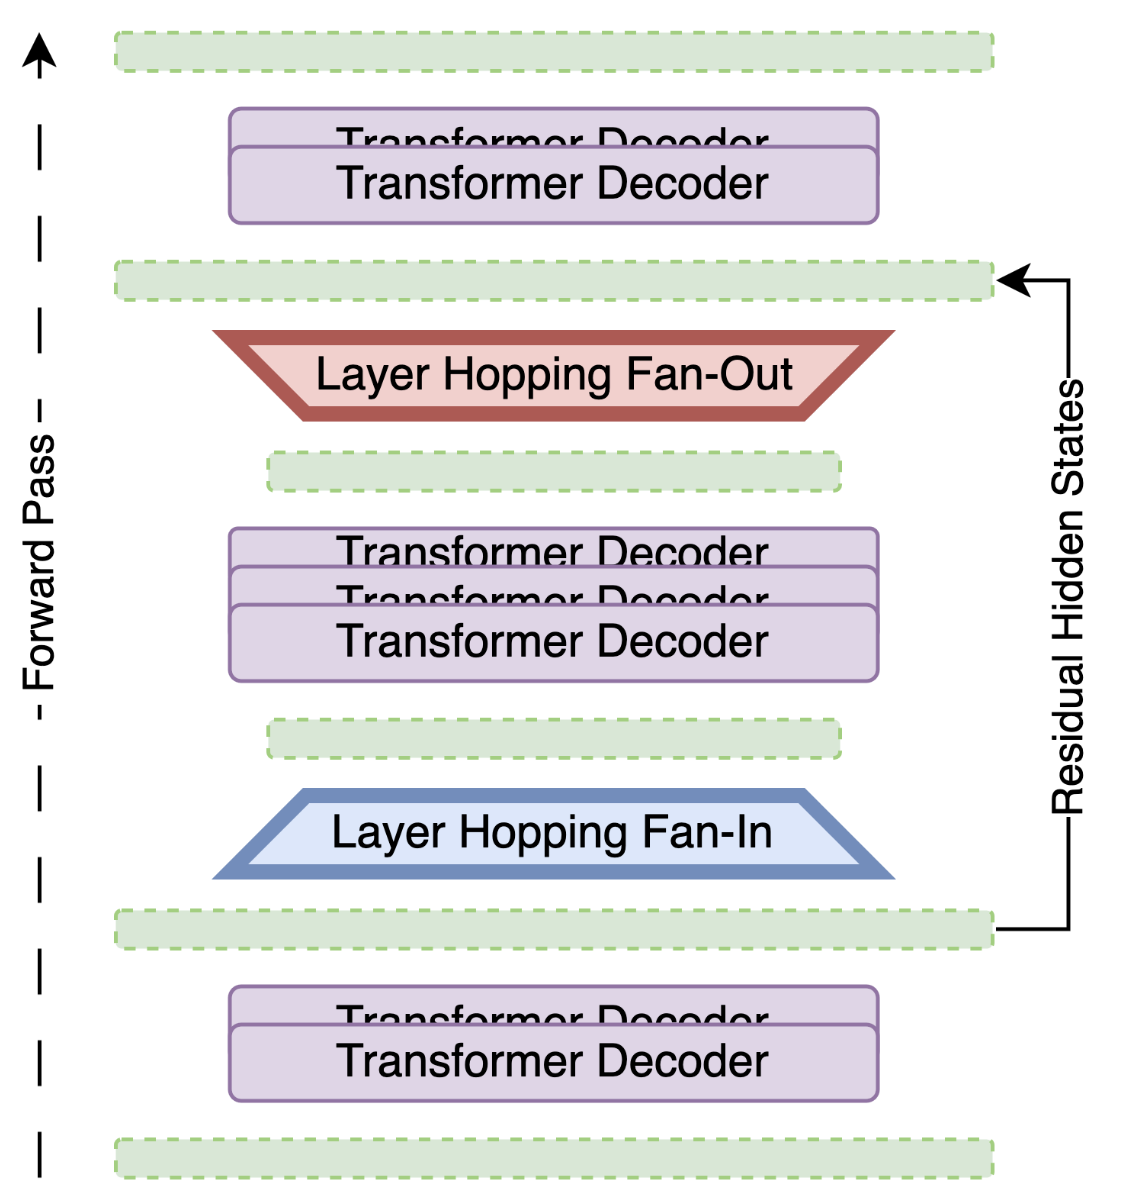


```
Batch Size   Seq Length    CUDA (ms)  Triton (ms) PyTorch (ms) CUDA Speedup Triton Speedup
-------------------------------------------------------------------------------------
         1          128         0.88        25.53        24.53        27.74x         0.96x
         1          256         1.23        45.14        44.12        35.91x         0.98x
         1          512         2.31        94.47        93.11        40.28x         0.99x
         1         1024         4.22       184.36       181.02        42.93x         0.98x
         4          128         0.91        94.83        93.40       102.72x         0.98x
         4          256         1.26       179.90       177.89       141.10x         0.99x
         4          512         6.50       369.58       367.27        56.53x         0.99x
         4         1024        19.48       725.06       719.75        36.96x         0.99x
         8          128         0.87       182.45       184.51       212.60x         1.01x
         8          256         1.32       356.69       356.21       270.10x         1.00x
         8          512        10.32       724.07       721.86        69.95x         1.00x
```

### Resources

* [How to Optimize a CUDA Matmul Kernel for cuBLAS-like Performance: a Worklog](https://siboehm.com/articles/22/CUDA-MMM)


## Profiling



### Memory

* [**Docs**](https://pytorch.org/blog/understanding-gpu-memory-1/)


In [ ]:
torch.cuda.memory._record_memory_history(
   max_entries=MAX_NUM_OF_MEM_EVENTS_PER_SNAPSHOT
)

# Run your PyTorch Model.
# At any point in time, save a snapshot to file for later.
for _ in range(5):
   pred = model(inputs)
   loss_fn(pred, labels).backward()
   optimizer.step()
   optimizer.zero_grad(set_to_none=True)

# In this sample, we save the snapshot after running 5 iterations.
#   - Save as many snapshots as you'd like.
#   - Snapshots will save last `max_entries` number of memory events
#     (100,000 in this example).
try:
   torch.cuda.memory._dump_snapshot(f"{file_prefix}.pickle")
except Exception as e:
   logger.error(f"Failed to capture memory snapshot {e}")

# Stop recording memory snapshot history.
torch.cuda.memory._record_memory_history(enabled=None)


### Original LLM

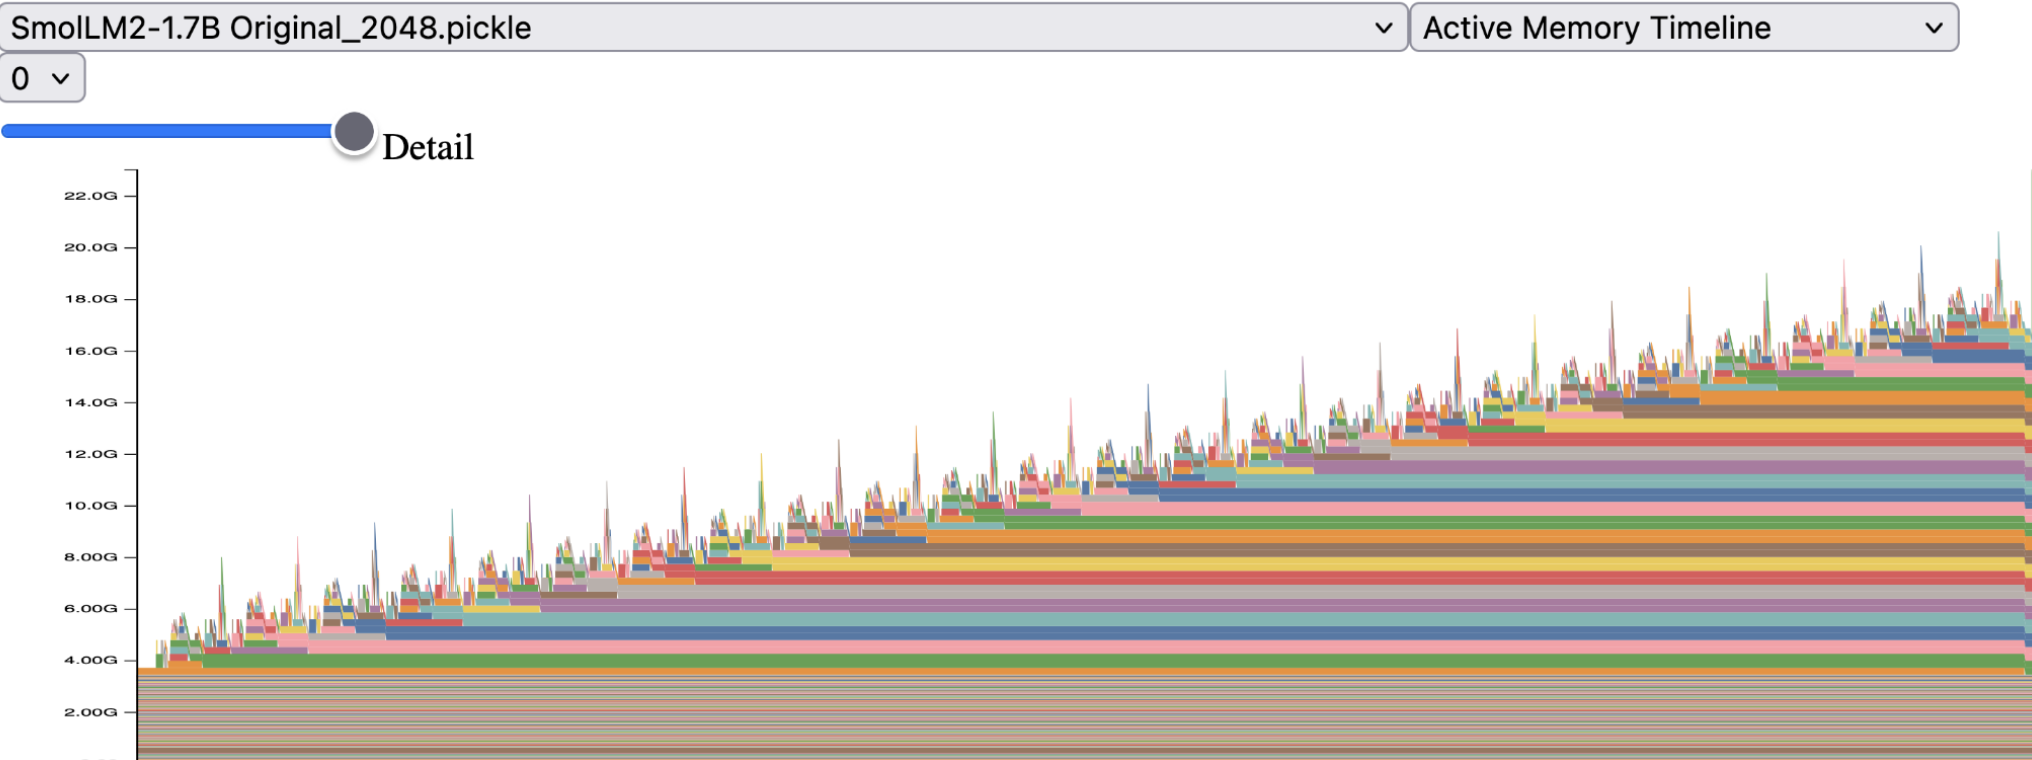

### TWLH LLM

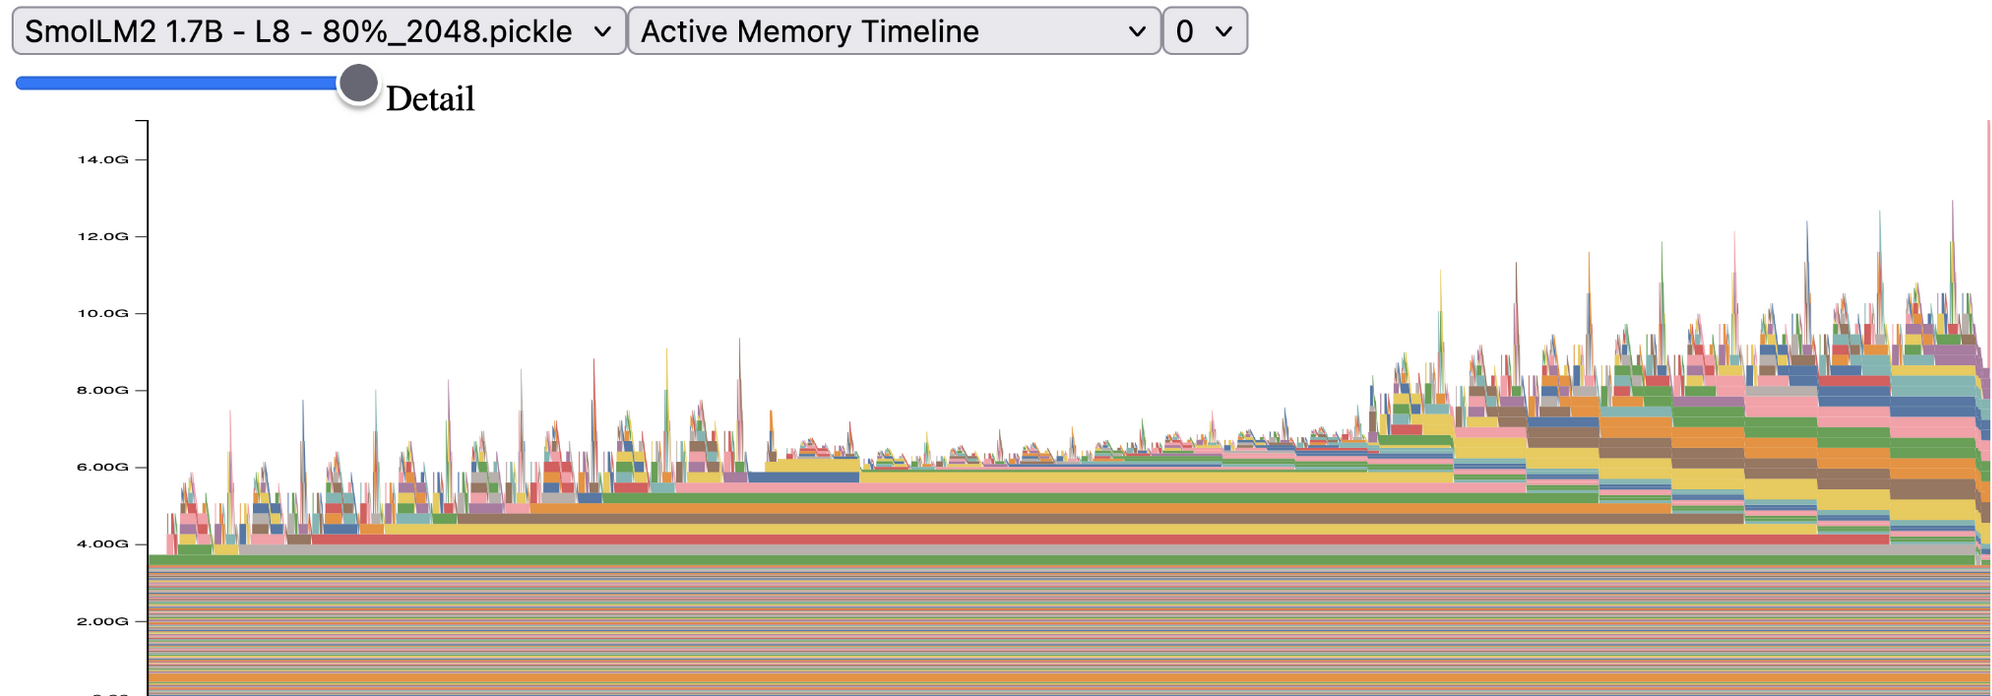

### Calculations

In [ ]:
from torch.profiler import profile, record_function, ProfilerActivity

activities = [ProfilerActivity.CPU, ProfilerActivity.CUDA, ProfilerActivity.XPU]

with profile(activities=activities, profile_memory=True, record_shapes=True, with_stack=True) as prof:
    with record_function("model_inference"):
        forward_output = current_model.forward(**text_inputs, use_cache=False)
        torch.cuda.synchronize()

prof.export_chrome_trace(f"trace_{i}_{type(current_model)}.json")

**TODO** go to chrome tracing

# Блиц

### Чем отличается `bfloat16` от `float16`?

### **GPU Memory Management**
Why might using gradient checkpointing actually increase the total computation time during training, despite reducing memory usage?


### **Mixed Precision**
Q: Why is sorting floating-point numbers before summing them considered a more numerically stable approach compared to naive summation, and how does this relate to mixed precision training?


### **PEFT (Parameter Efficient Fine-Tuning)**
Q: Compare and contrast how Prompt Tuning and LoRA achieve parameter efficiency - which approach would you choose for a task where maintaining the original model's knowledge is crucial?


### **CUDA Kernel Optimization**
Q: How does kernel fusion improve performance beyond just reducing kernel launch overhead, and what factors should you consider before deciding to fuse two kernels?

### **CUDA Async Nature**
Q: Why is it crucial to use `torch.cuda.synchronize()` when measuring CUDA operation execution times, and what might happen if you don't?

## Домашка 

#### TODO